In [1]:
import matplotlib.pyplot as plt
import glob
import os
import json
import numpy as np
import pandas as pd
from scipy import stats
from pandas import MultiIndex
from sklearn.metrics import mean_squared_error,mean_absolute_error
from orbit.utils.dataset import load_m3monthly
from tqdm import tqdm
from pandas import read_excel
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["font.size"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["legend.handlelength"] = 2

d:\anaconda3\envs\Internship\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
d:\anaconda3\envs\Internship\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
def load_json(base='./json_data',target_file=None):
    datas=[]
    file_path = base + target_file
    with open(file_path,'r') as file:
        for line in file.readlines():
            datas.append(json.loads(line))
    return datas

def load_m3_data(min_length=100, n_set=1500):
    datasets = dict()
    m3_data = load_m3monthly()
    keys = m3_data['key'].unique().tolist()

    print('Loading M3 dataset')
    for key in keys:
        current = m3_data[m3_data['key'] == key]
        if current.shape[0] > min_length:
            datasets[key] = current['value'].to_numpy()
            if len(datasets.keys()) == n_set:
                break

    print(f'Get {len(datasets)} datasets with length > {min_length}')
    return datasets

In [3]:
def evaluate(test_data,forecast_data,index,method):
        a = np.array(test_data)
        f = np.array(forecast_data)

        rmse = np.sqrt(mean_squared_error(a, f))
        smape = np.mean(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))*100
        mae = mean_absolute_error(a, f)
        rae = np.sum(np.abs(a-f))/np.sum(np.abs(a-np.mean(a)))
        scores = pd.DataFrame({'RMSE':[rmse],'SMAPE':[smape],'RAE':[rae],'MAE':[mae]},index=[[index],[method]])

        return scores

In [4]:
def acf(data, k):
        """
        Autocorrelation function
        :param data: time series
        :param k: lag
        :return:
        """
        m = np.mean(data)
        s1 = 0
        for i in range(k, len(data)):
            s1 = s1 + ((data[i] - m) * (data[i - k] - m))

        s2 = 0
        for i in range(0, len(data)):
            s2 = s2 + ((data[i] - m) ** 2)

        return float(s1 / s2)
    
def seasonality_test(original_ts, ppy=12):
    """
    Seasonality test
    :param original_ts: time series
    :param ppy: periods per year
    :return: boolean value: whether the TS is seasonal
    """
    
    # Note that the statistical benchmarks, implemented in R, use the same seasonality test, but with ACF1 being squared
    # This difference between the two scripts was mentioned after the end of the competition and, therefore, no changes have been made 
    # to the existing code so that the results of the original submissions are reproducible
    s = acf(original_ts, 1)**2
    for i in range(2, ppy):
        s = s + (acf(original_ts, i) ** 2)

    limit = 1.645 * (np.sqrt((1 + 2 * s) / len(original_ts)))

    return (np.abs(acf(original_ts, ppy))) > limit

In [5]:
def adf_test(timeseries):
    # print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput['p-value'] > 0.1

def kpss_test(timeseries):
    # print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return kpss_output['p-value'] < 0.1

In [6]:
def plot_box(smape_df,name):
    for model in ['NAIVE', 'ENET', 'ARIMA', 'KNN', 'CART', 'SVR', 'MLP',]:
        df = smape_df.xs(model, axis=1)
        smape_mean = pd.DataFrame(df.mean(axis=0),columns=['SMAPE MEAN'])
        # print([f'{m}({t[0]})'])
        plt.figure()
        label = f" {smape_mean}"
        df.boxplot(grid=False, showfliers=False,autorange=True,widths=0.3)
        # plt.legend([label],handlelength=0, handletextpad=0,loc=6)
        plt.title(f'{model} {name}')

In [7]:
datas = load_json(target_file='./m3_origin.json')
datas_trend = load_json(target_file='./m3_detrend.json')
all_data = load_m3_data()

Loading M3 dataset


100%|██████████| 1399/1399 [00:08<00:00, 169.38it/s]

Get 1043 datasets with length > 100


In [8]:
m3_data = read_excel('./Dataset/M3C.xls',sheet_name='M3Month')
m3_data.set_index(["Series"], inplace=True)
m3_info = pd.DataFrame(m3_data.loc[:,'Category'])

### Load SMAPE

In [9]:
def evaluate_df(datas):
    smape_df = pd.DataFrame()

    for data in datas:
        all_scores = pd.DataFrame()

        # Read test set
        train = data['train_test']['train']
        test = data['train_test']['test']

        for model in data['transformed'].keys():
            all_scores = pd.concat([all_scores,evaluate(test,data['untransformed'][model],model,'untrans')],axis=0)
            all_scores = pd.concat([all_scores,evaluate(test,data['transformed'][model],model,'trans')],axis=0)
        
        smape_df[data['dataset_info']['dataset_name']]= all_scores['SMAPE']

        
    smape_df = smape_df.T
    smape_df.sort_index(inplace=True)
    return smape_df

In [10]:
smape_df = evaluate_df(datas)
smape_df_trend = evaluate_df(datas_trend)

C:\Users\Huiqi Luo\AppData\Local\Temp\ipykernel_41516\2424991327.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smape_df[data_arima['dataset_info']['dataset_name']]= all_scores['SMAPE']
C:\Users\Huiqi Luo\AppData\Local\Temp\ipykernel_41516\2424991327.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  smape_df[data_arima['dataset_info']['dataset_name']]= all_scores['SMAPE']
C:\Users\Huiqi Luo\AppData\Local\Temp\ipykernel_41516\2424991327.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [11]:
cols = pd.MultiIndex.from_tuples([('ARIMA', 'untrans'),
            ('ARIMA',   'trans'),
            ('ENET', 'untrans'),
            ('ENET',   'trans'),
            ('SVR', 'untrans'),
            ('SVR',   'trans'),
            ('KNN', 'untrans'),
            ('KNN',   'trans'),
            ('CART', 'untrans'),
            ('CART',   'trans'),
            ('MLP', 'untrans'),
            ('MLP',   'trans'),
            ('ETS',   'untrans'),
            ('ETS',   'trans'),
            ('NAIVE', 'untrans'),
            ('NAIVE',   'trans'),])

smape_df.columns = cols
smape_df_trend.columns = cols


### SMAPE Mean & STD

In [12]:
smape_df.mean(axis=0)

ARIMA  untrans     8.730665
       trans      10.583805
ENET   untrans     7.828801
       trans      10.281806
SVR    untrans    11.047057
       trans      10.443732
KNN    untrans     9.357573
       trans      10.510842
CART   untrans    10.198561
       trans      10.412381
MLP    untrans    17.402318
       trans      18.088425
ETS    untrans     9.061397
       trans      10.244596
NAIVE  untrans     9.495073
       trans      10.213183
dtype: float64

In [13]:
smape_df_trend.mean(axis=0)

ARIMA  untrans    22.850024
       trans      28.631778
ENET   untrans    16.081222
       trans      16.063377
SVR    untrans    19.321716
       trans      16.221687
KNN    untrans    16.439535
       trans      16.313249
CART   untrans    18.098565
       trans      16.318187
MLP    untrans    18.733819
       trans      16.390797
ETS    untrans    15.523889
       trans      16.061382
NAIVE  untrans    16.100830
       trans      15.997547
dtype: float64

In [14]:
smape_df_trend.std()

ARIMA  untrans    27.020279
       trans      24.824876
ENET   untrans    25.772375
       trans      25.536967
SVR    untrans    27.609146
       trans      25.584808
KNN    untrans    25.367523
       trans      25.283011
CART   untrans    26.766480
       trans      25.607144
MLP    untrans    27.300248
       trans      25.583620
ETS    untrans    25.476923
       trans      25.477805
NAIVE  untrans    25.575706
       trans      25.473618
dtype: float64

In [15]:
smape_df.std()

ARIMA  untrans    11.688270
       trans      15.315908
ENET   untrans    10.268182
       trans      15.130124
SVR    untrans    14.335172
       trans      15.359546
KNN    untrans    10.335335
       trans      14.120419
CART   untrans    12.737500
       trans      14.906893
MLP    untrans    11.609505
       trans      14.346669
ETS    untrans    12.019069
       trans      12.898028
NAIVE  untrans    11.834503
       trans      12.866602
dtype: float64

### SMAPE Box plot 

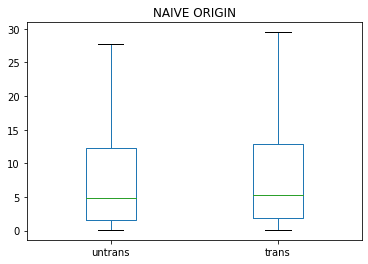

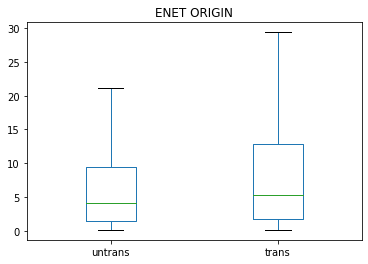

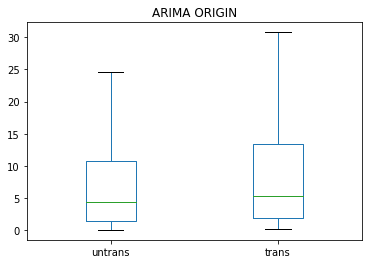

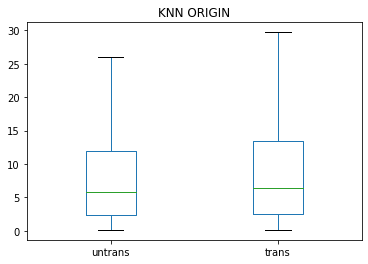

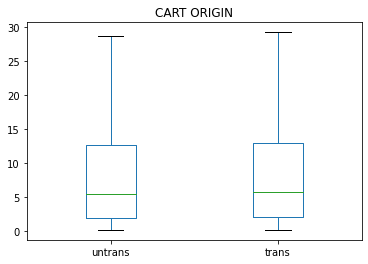

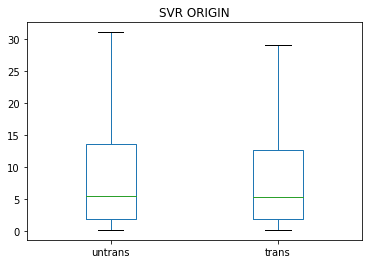

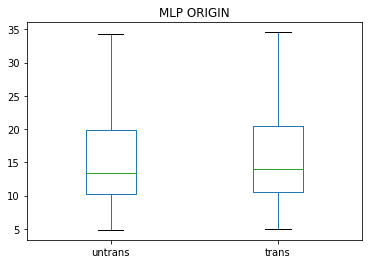

In [16]:
plot_box(smape_df,'ORIGIN')

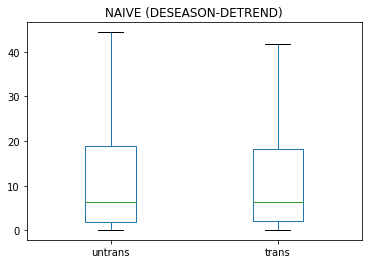

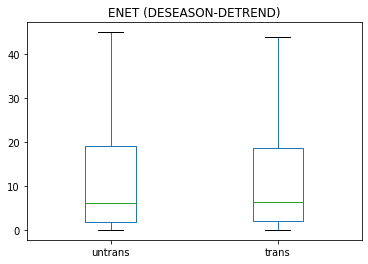

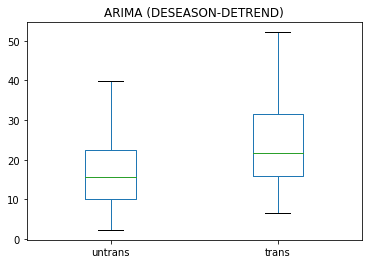

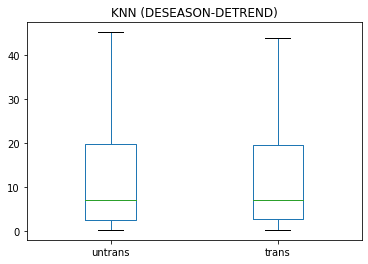

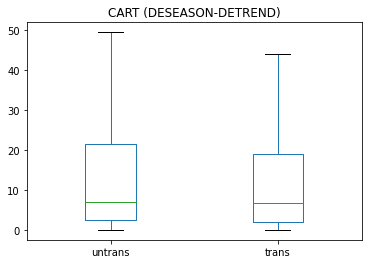

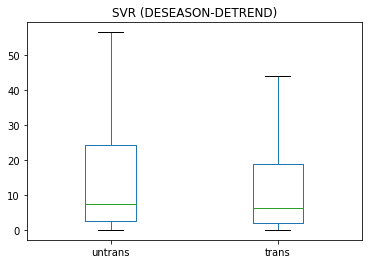

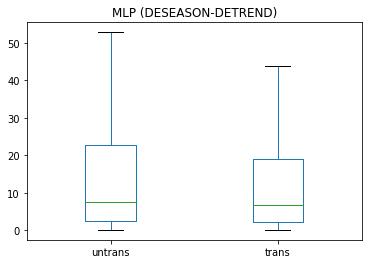

In [17]:
plot_box(smape_df_trend,'(DESEASON-DETREND)')

### Seasonality & Stationary test

In [18]:
seasonal = pd.DataFrame()
adf = pd.DataFrame()
Kpss = pd.DataFrame()

for key in all_data.keys():
    seasonal[key] = [seasonality_test(all_data[key])]
    adf[key] = [adf_test(all_data[key])]
    Kpss[key] = [kpss_test(all_data[key])]
adf = adf.T
Kpss = Kpss.T
seasonal = seasonal.T
seasonal.columns = ['Seasonal']
adf.columns = ['adf-test']
Kpss.columns = ['kpss-test']

d:\anaconda3\envs\Internship\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
d:\anaconda3\envs\Internship\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
d:\anaconda3\envs\Internship\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
d:\anaconda3\envs\Internship\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual 

### Add Category, Seasonal-test, Stationary-test

In [19]:
smape_df.fillna(0,inplace=True)

In [20]:
df_all = pd.concat([smape_df,m3_info],axis=1)
df_all.dropna(how='any',inplace=True)
df_all = pd.concat([df_all,seasonal,adf,Kpss],axis=1)

### Seasonal & Non-Seasonal

##### adf = False & kpss = False (both stationary)
##### The series is stationary

In [21]:
stationary = df_all[(df_all['adf-test']==False) & (df_all['kpss-test']==False)].iloc[:,:-4]
stationary.columns = cols
stationary['stationary'] = True
# stationary

##### adf = True & kpss = True (both nonstationary)
##### The series is not stationary

In [22]:
nonstationary = df_all[(df_all['adf-test']==True) & (df_all['kpss-test']==True)].iloc[:,:-4]
nonstationary.columns = cols
nonstationary['stationary'] = False
# nonstationary

##### adf = True & kpss = False (adf: nonstationary; kpss: stationary)
##### The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity

In [23]:
trend_stationary = df_all[(df_all['adf-test']==True) & (df_all['kpss-test']==False)].iloc[:,:-4]
trend_stationary.columns = cols
trend_stationary['stationary'] = True
# trend_stationary

##### adf = False & kpss = True (adf: stationary; kpss: nonstationary)
##### The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [24]:
diff_stationary = df_all[(df_all['adf-test']==False) & (df_all['kpss-test']==True)].iloc[:,:-4]
diff_stationary.columns = cols
diff_stationary['stationary'] = True

In [25]:
test = pd.concat([stationary, nonstationary, trend_stationary, diff_stationary],axis=0)
df_all = pd.concat([df_all,test['stationary']],axis=1)

##### ORIGIN

In [26]:
summary = df_all.groupby(['Seasonal','stationary']).mean().iloc[:,:-2]
summary.columns = cols
summary

ARIMA                  ENET                   SVR  \
                       untrans      trans    untrans      trans    untrans   
Seasonal stationary                                                          
False    False        5.534259   6.712565   5.895358   6.641840   8.102787   
         True        13.053768  12.710803  11.260457  12.570259  15.905883   
True     False        7.772395   9.823266   7.099946   9.512376   9.939746   
         True        12.895721  16.038602  10.486678  15.468654  15.392041   

                                      KNN                  CART             \
                         trans    untrans      trans    untrans      trans   
Seasonal stationary                                                          
False    False        6.702357   9.148290   9.259740   7.675908   6.812180   
         True        13.058693  12.472366  12.848700  14.765003  12.994958   
True     False        9.625776   8.591082   9.697538   9.208237   9.659710   
         True        15.702879  11.150991  14.038425  13.810427  15.224546   

                           MLP                   ETS                 NAIVE  \
                       untrans      trans    untrans      trans    untrans   
Seasonal stationary                                                          
False    False       16.836622  15.910901   5.784760   6.458727   6.123434   
         True        21.013938  21.505460  12.151176  13.066206  12.063235   
True     False       16.679068  17.208233   8.276940   9.213754   8.723226   
         True        18.809663  21.793869  12.796665  15.905842  13.650266   

                                
                         trans  
Seasonal stationary             
False    False        6.531453  
         True        12.577723  
True     False        9.213132  
         True        16.012013

In [27]:
df_all_trend = pd.concat([smape_df_trend,m3_info],axis=1)
df_all_trend.dropna(how='any',inplace=True)
df_all_trend = pd.concat([df_all_trend,seasonal,adf,Kpss],axis=1)

stationary_trend = df_all_trend[(df_all_trend['adf-test']==False) & (df_all_trend['kpss-test']==False)].iloc[:,:-4]
stationary_trend.columns = cols
stationary_trend['stationary'] = True

nonstationary_trend = df_all_trend[(df_all_trend['adf-test']==True) & (df_all_trend['kpss-test']==True)].iloc[:,:-4]
nonstationary_trend.columns = cols
nonstationary_trend['stationary'] = False

trend_stationary_trend = df_all_trend[(df_all_trend['adf-test']==True) & (df_all_trend['kpss-test']==False)].iloc[:,:-4]
trend_stationary_trend.columns = cols
trend_stationary_trend['stationary'] = True

diff_stationary_trend = df_all_trend[(df_all['adf-test']==False) & (df_all_trend['kpss-test']==True)].iloc[:,:-4]
diff_stationary_trend.columns = cols
diff_stationary_trend['stationary'] = True

test_trend = pd.concat([stationary_trend, nonstationary_trend, trend_stationary_trend, diff_stationary_trend],axis=0)
df_all_trend = pd.concat([df_all_trend,test_trend['stationary']],axis=1)

##### DESEASON-DETREND

In [28]:
summary_trend = df_all_trend.groupby(['Seasonal','stationary']).mean().iloc[:,:-2]
summary_trend.columns = cols
summary_trend

ARIMA                  ENET                   SVR  \
                       untrans      trans    untrans      trans    untrans   
Seasonal stationary                                                          
False    False       19.008985  27.297309   6.272007   6.819448   8.964922   
         True        20.970534  26.762084  11.891520  13.052283  17.399191   
True     False       21.976873  27.329154  16.660253  16.502385  19.476482   
         True        32.317041  38.534135  24.058131  23.379049  28.166016   

                                      KNN                  CART             \
                         trans    untrans      trans    untrans      trans   
Seasonal stationary                                                          
False    False        7.084041   7.780574   7.789089   8.007880   6.837989   
         True        13.356294  13.040051  13.283165  14.776378  13.703139   
True     False       16.615024  16.881129  16.714014  18.526811  16.756026   
         True        23.585577  23.615057  23.297487  26.398945  23.487769   

                           MLP                   ETS                 NAIVE  \
                       untrans      trans    untrans      trans    untrans   
Seasonal stationary                                                          
False    False        8.667183   7.174224   5.904728   6.728443   6.406800   
         True        16.164681  13.574308  11.791251  13.160638  12.616493   
True     False       19.061383  16.817981  16.110773  16.495893  16.608133   
         True        26.937135  23.585664  22.920118  23.377702  23.788546   

                                
                         trans  
Seasonal stationary             
False    False        6.749065  
         True        13.117296  
True     False       16.428334  
         True        23.251393

In [29]:
df_all.groupby(['Seasonal','stationary']).count()

(ARIMA, untrans)  (ARIMA, trans)  (ENET, untrans)  \
Seasonal stationary                                                      
False    False                     99              99               99   
         True                     108             108              108   
True     False                    709             709              709   
         True                     127             127              127   

                     (ENET, trans)  (SVR, untrans)  (SVR, trans)  \
Seasonal stationary                                                
False    False                  99              99            99   
         True                  108             108           108   
True     False                 709             709           709   
         True                  127             127           127   

                     (KNN, untrans)  (KNN, trans)  (CART, untrans)  \
Seasonal stationary                                                  
False    False                   99            99               99   
         True                   108           108              108   
True     False                  709           709              709   
         True                   127           127              127   

                     (CART, trans)  (MLP, untrans)  (MLP, trans)  \
Seasonal stationary                                                
False    False                  99              99            99   
         True                  108             108           108   
True     False                 709             709           709   
         True                  127             127           127   

                     (ETS, untrans)  (ETS, trans)  (NAIVE, untrans)  \
Seasonal stationary                                                   
False    False                   99            99                99   
         True                   108           108               108   
True     False                  709           709               709   
         True                   127           127               127   

                     (NAIVE, trans)  Category  adf-test  kpss-test  
Seasonal stationary                                                 
False    False                   99        99        99         99  
         True                   108       108       108        108  
True     False                  709       709       709        709  
         True                   127       127       127        127

#### Average SMAPE by Category

In [30]:
domain = df_all.groupby(['Category']).mean().iloc[:,:-4]
domain.columns = cols
domain

ARIMA                  ENET                   SVR  \
                untrans      trans    untrans      trans    untrans   
Category                                                              
DEMOGRAPHIC    3.092633   3.065995   2.072443   2.944080   3.043249   
FINANCE        6.873541  10.475428   6.762413  10.305449   9.241551   
INDUSTRY       9.908980  11.606743   8.366265  11.320650  11.744253   
MACRO          3.420321   4.742975   2.888709   4.627690   3.834809   
MICRO         18.373570  21.099118  17.552323  20.320938  25.297146   
OTHER         25.334123  25.489210  25.140590  25.344610  42.571885   

                               KNN                  CART             \
                  trans    untrans      trans    untrans      trans   
Category                                                              
DEMOGRAPHIC    3.121137   4.041943   4.538892   2.843866   3.212805   
FINANCE       10.502430   8.808223  11.355716   8.040250  10.522011   
INDUSTRY      11.449340  10.191760  11.480048  11.137584  11.409612   
MACRO          4.658757   4.638891   5.668510   3.742164   4.819761   
MICRO         20.708628  17.762993  18.317912  22.914479  20.281027   
OTHER         25.629619  22.772878  24.114430  31.332160  28.552945   

                    MLP                   ETS                 NAIVE             
                untrans      trans    untrans      trans    untrans      trans  
Category                                                                        
DEMOGRAPHIC   13.370245  14.037211   2.214286   2.818216   2.241927   2.896858  
FINANCE       16.464933  18.091100   7.331639   8.490564   8.419091   8.731694  
INDUSTRY      17.009416  18.469605  10.436294  11.648335  10.470973  11.483909  
MACRO         12.605384  13.296663   3.338755   4.092464   3.725961   4.106964  
MICRO         27.616019  26.395494  19.119976  21.118521  19.929160  21.025303  
OTHER         34.466070  37.282820  24.291837  27.588094  38.125041  27.588218

In [31]:
domain_trend = df_all_trend.groupby(['Category']).mean().iloc[:,:-4]
domain_trend.columns = cols
domain_trend

ARIMA                  ENET                   SVR  \
                untrans      trans    untrans      trans    untrans   
Category                                                              
DEMOGRAPHIC   14.616432  42.983751   5.768594   5.932048   6.633184   
FINANCE       24.035030  36.610586  17.326100  17.753096  19.571967   
INDUSTRY      21.761299  25.034059  20.070750  20.594117  23.140692   
MACRO         14.626020  23.371892   6.668297   6.900496   7.760124   
MICRO         39.845584  31.146757  27.337989  25.670450  35.798705   
OTHER         62.479335  40.352507  43.725138  43.512285  50.561448   

                               KNN                  CART             \
                  trans    untrans      trans    untrans      trans   
Category                                                              
DEMOGRAPHIC    6.042966   6.356727   6.333262   6.168243   6.208429   
FINANCE       18.013782  18.389321  18.487002  18.392635  18.053552   
INDUSTRY      20.703726  20.765835  20.784127  21.728092  20.667231   
MACRO          6.970590   7.354251   7.367323   7.357657   7.018559   
MICRO         25.995872  26.122873  25.363540  33.223470  26.410055   
OTHER         44.490263  40.858550  39.934595  54.188752  43.047143   

                    MLP                   ETS                 NAIVE             
                untrans      trans    untrans      trans    untrans      trans  
Category                                                                        
DEMOGRAPHIC    6.425851   6.321597   5.898571   5.994471   5.806656   5.994735  
FINANCE       20.030244  18.314100  16.836285  17.716907  17.654919  17.762493  
INDUSTRY      22.261641  20.833776  19.691582  20.489001  20.249989  20.376271  
MACRO          7.756084   7.127264   6.545361   6.890274   6.758661   6.921501  
MICRO         33.940959  26.134208  25.490280  25.804511  26.688307  25.581711  
OTHER         55.533497  43.192982  40.432190  47.682527  52.940214  47.653908

In [32]:
domain.to_excel('domain.xlsx')
domain_trend.to_excel('domain_trend.xlsx')

In [33]:
summary

ARIMA                  ENET                   SVR  \
                       untrans      trans    untrans      trans    untrans   
Seasonal stationary                                                          
False    False        5.534259   6.712565   5.895358   6.641840   8.102787   
         True        13.053768  12.710803  11.260457  12.570259  15.905883   
True     False        7.772395   9.823266   7.099946   9.512376   9.939746   
         True        12.895721  16.038602  10.486678  15.468654  15.392041   

                                      KNN                  CART             \
                         trans    untrans      trans    untrans      trans   
Seasonal stationary                                                          
False    False        6.702357   9.148290   9.259740   7.675908   6.812180   
         True        13.058693  12.472366  12.848700  14.765003  12.994958   
True     False        9.625776   8.591082   9.697538   9.208237   9.659710   
         True        15.702879  11.150991  14.038425  13.810427  15.224546   

                           MLP                   ETS                 NAIVE  \
                       untrans      trans    untrans      trans    untrans   
Seasonal stationary                                                          
False    False       16.836622  15.910901   5.784760   6.458727   6.123434   
         True        21.013938  21.505460  12.151176  13.066206  12.063235   
True     False       16.679068  17.208233   8.276940   9.213754   8.723226   
         True        18.809663  21.793869  12.796665  15.905842  13.650266   

                                
                         trans  
Seasonal stationary             
False    False        6.531453  
         True        12.577723  
True     False        9.213132  
         True        16.012013

In [34]:
summary.to_excel('origin.xlsx')
summary_trend.to_excel('trend.xlsx')


In [35]:
pd.DataFrame(smape_df.mean(axis=0)).T

ARIMA                 ENET                   SVR                  KNN  \
    untrans      trans   untrans      trans    untrans      trans   untrans   
0  8.730665  10.583805  7.828801  10.281806  11.047057  10.443732  9.357573   

                   CART                   MLP                  ETS             \
       trans    untrans      trans    untrans      trans   untrans      trans   
0  10.510842  10.198561  10.412381  17.402318  18.088425  8.991894  10.166019   

      NAIVE             
    untrans      trans  
0  9.422244  10.134846

#### MLP

In [36]:
mlp_detrend = smape_df_trend['MLP']
mlp_detrend.columns = ['untrans-2','trans-2']

In [37]:
mlp_origin = smape_df['MLP']
mlp_origin.columns = ['untrans-1','trans-1']

In [38]:
mlp = pd.concat([mlp_origin,mlp_detrend],axis=1)

In [40]:
def plot_prediction(datas, datas_trend, smape_df, model, dataset_name='N1682'):
        
        plt.rcParams["figure.figsize"] = (12, 10)
        plt.rcParams["font.size"] = 14
        plt.rcParams["legend.fontsize"] = 14
        plt.rcParams["legend.handlelength"] = 2

        df = pd.DataFrame()

        for data in datas:
            if dataset_name and data['name'] != dataset_name:
                continue

            for data1 in datas_trend:
                if data1['name'] == dataset_name:
                    
                    train = np.array(data['train_y']).ravel()
                    test = np.array(data['test_y']).ravel()
                    
                    train_time_idx = range(len(train)+len(test))[:len(train)]
                    test_time_idx = range(len(train)+len(test))[len(train):]
                    
                    smape = format(smape_df.loc[dataset_name]['untrans-1'],'.4f')
                    smape2 = format(smape_df.loc[dataset_name]['trans-1'],'.4f')
                    smape3 = format(smape_df.loc[dataset_name]['untrans-2'],'.4f')
                    smape4 = format(smape_df.loc[dataset_name]['trans-2'],'.4f')

                    fig, axes = plt.subplots(3, 1)
                    axes[0].set_title(f'{data["name"]}, Model: MLP')
                    
                    axes[0].plot(data['series'],label='Original Time Series')
                    axes[1].plot(data['series'])
                    axes[2].plot(data['series'])

                    axes[0].legend()
                    axes[1].plot(test_time_idx, data['untransformed'][model]['prediction'],label=f'untrans, SMAPE = {smape}')
                    axes[1].plot(test_time_idx, data['transformed'][model]['prediction'],label=f'trans, SMAPE = {smape2}')
                    axes[1].set_title('ORIGIN')
                    axes[1].legend()
                    axes[2].plot(test_time_idx, data1['untransformed'][model]['prediction'],label=f'untrans, SMAPE = {smape3}')
                    axes[2].plot(test_time_idx, data1['transformed'][model]['prediction'],label=f'trans, SMAPE = {smape4}')
                    axes[2].set_title('DESEASON-DETREND')
                    plt.legend()

        plt.tight_layout()
        plt.show()

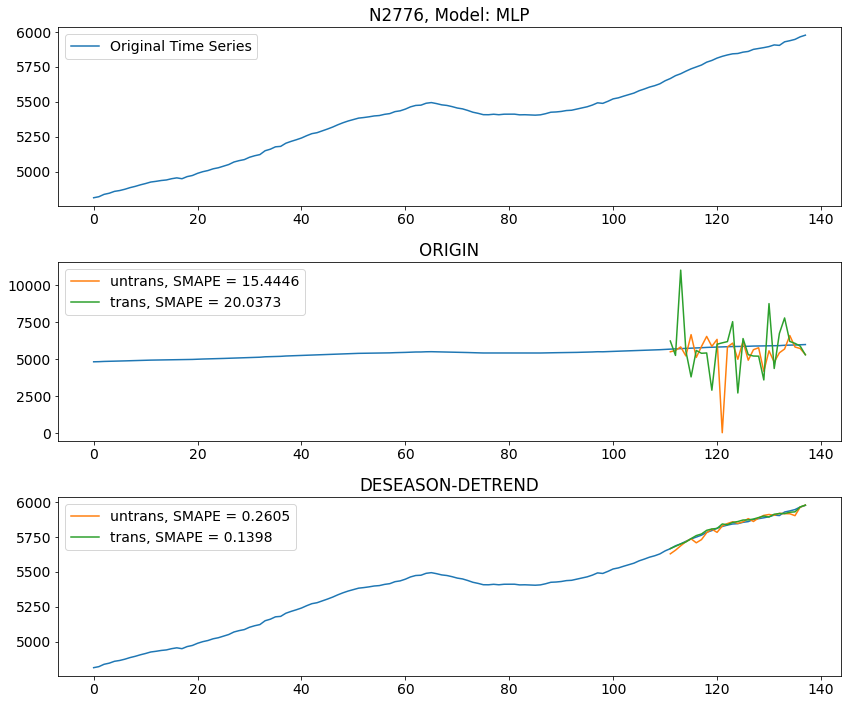

In [41]:
plot_prediction(datas,datas_trend,mlp,'MLPRegressor',dataset_name='N2776')

In [42]:
arima_improve = smape_df[smape_df[('ARIMA','untrans')]>smape_df[('ARIMA','trans')]]['ARIMA']
enet_improve = smape_df[smape_df[('ENET','untrans')]>smape_df[('ENET','trans')]]['ENET']
svr_improve = smape_df[smape_df[('SVR','untrans')]>smape_df[('SVR','trans')]]['SVR']
knn_improve = smape_df[smape_df[('KNN','untrans')]>smape_df[('KNN','trans')]]['KNN']
cart_improve = smape_df[smape_df[('CART','untrans')]>smape_df[('CART','trans')]]['CART']
mlp_improve = smape_df[smape_df[('MLP','untrans')]>smape_df[('MLP','trans')]]['MLP']
ets_improve = smape_df[smape_df[('ETS','untrans')]>smape_df[('ETS','trans')]]['ETS']


In [ ]:
def plot_increase_one(datas, smape_df, model, rename, dataset_name=['N1682','N2783','N2775']):
    
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.rcParams["font.size"] = 14
    plt.rcParams["legend.fontsize"] = 14
    plt.rcParams["legend.handlelength"] = 2


    fig, axes = plt.subplots(len(dataset_name), 1)
    i = 0
    for name in dataset_name:
        for data in datas:
            if data['dataset_info']['dataset_name'] == name:
                train = np.array(data['train_test']['train']).ravel()
                test = np.array(data['train_test']['test']).ravel()
                
                test_time_idx = range(len(train)+len(test))[len(train):]
                
                smape = format(smape_df[i].loc[name]['untrans'],'.4f')
                smape2 = format(smape_df[i].loc[name]['trans'],'.4f')             
                
                axes[i].plot(data['series'],label='Original Time Series')
                axes[i].plot(test_time_idx, data['untransformed'][model[i]],label=f'untrans, SMAPE = {smape}')
                axes[i].plot(test_time_idx, data['transformed'][model[i]],label=f'trans, SMAPE = {smape2}')
                axes[i].set_title(f'{name}, Model: {rename[i]}')
                axes[i].legend()
                i = i+ 1
        
    plt.tight_layout()
    plt.show()

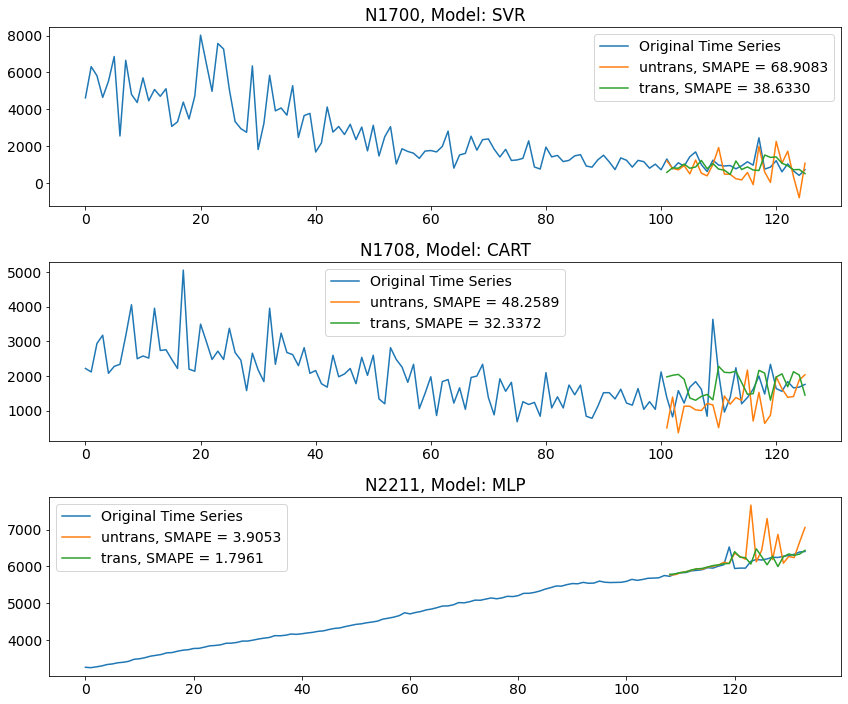

In [ ]:
plot_increase_one(datas_trend,[svr_improve_trend,cart_improve_trend,mlp_improve_trend],['LinearSVR','RandomForestRegressor', 'MLPRegressor'],['SVR','CART','MLP'],dataset_name=['N1700','N1708','N2211'])